## UATSAD: Toy Example Visualization 
In this notebook we will:
- Getting Data
- Training and Test
- Predict and Plot

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Configure 

import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from model import AutoEncoder
from dataloader import AESegLoader


class Config:
    # model
    in_channel = 1
    win_size = 64
    latent_dim = 10
    hidden_num_units = 64

    n_epochs = 15
    lr = 1e-3
    batch_size = 32
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()



1. Get the data of different anomalies:
- anomaly value = 10
- anomaly value = 20
- anomaly value = 30

In [5]:

import matplotlib.pyplot as plt
import utils

generator = utils.Synthetic_heteroscedasticData_generator(0.7, 2, 5, 10)

data = generator.get_data(1000)

y_tildes = data['y_tilde'].clone().detach()
y_tildes_test = data['y_disturb_tilde'].clone().detach()

scaler = StandardScaler()
scaler.fit(y_tildes)
y_tildes = scaler.transform(y_tildes)
y_tildes_test = scaler.transform(y_tildes_test)
ys = data['y'].clone().detach()

print(y_tildes.shape)


(1000, 1)


In [6]:

import matplotlib.pyplot as plt
import utils

generator = utils.Synthetic_heteroscedasticData_generator(2, 2, 5, 20)
data = generator.get_data(1000)

y_tildes = data['y_tilde'].clone().detach()
y_tildes_test = data['y_disturb_tilde'].clone().detach()

scaler = StandardScaler()
scaler.fit(y_tildes)
y_tildes = scaler.transform(y_tildes)
y_tildes_test = scaler.transform(y_tildes_test)
ys = data['y'].clone().detach()

print(y_tildes.shape)


(1000, 1)


In [7]:

import matplotlib.pyplot as plt
import utils

generator = utils.Synthetic_heteroscedasticData_generator(0.7, 2, 5, 30)
data = generator.get_data(1000)

y_tildes = data['y_tilde'].clone().detach()
y_tildes_test = data['y_disturb_tilde'].clone().detach()

scaler = StandardScaler()
scaler.fit(y_tildes)
y_tildes = scaler.transform(y_tildes)
y_tildes_test = scaler.transform(y_tildes_test)
ys = data['y'].clone().detach()

print(y_tildes.shape)


(1000, 1)


2. Training

In [ ]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from bae_ensemble import BAE_Ensemble
M = 20
config.batch_size = 16
bae_ens = BAE_Ensemble(M, AutoEncoder, config)
bae_ens.toDevice(config.device)


config.n_epochs = 5
def valid(data_loader):
    bae_ens.eval()
    total_loss = []
    with torch.no_grad():
        for i, x in enumerate(data_loader):
            x = x.view(config.batch_size, config.in_channel, -1)
            x = x.to(config.device)
            loss = bae_ens.fit(x)
            total_loss.append(loss.item())
    return np.average(total_loss)


def train(data_loader, bae_ens, config, tunning=False):
    bae_ens.train()
    for epoch in range(config.n_epochs):
        print(f"-------------- epoch: {epoch} ----------------")
        total_loss = []
        for i, x in enumerate(data_loader):
            bae_ens.zero_optimizers()
            x = x.view(config.batch_size, config.in_channel, -1) 
            x = x.to(config.device)
            x.requires_grad = False
            loss = bae_ens.fit(x)
            total_loss.append(loss.item())
            if (i + 1) % 20 == 0:
                print(f"     batch: {i + 1}, batch_loss: {loss.item()}     ")
            loss.backward()
            bae_ens.step_optimizers()
        if tunning:
            bae_ens.adjust_lr(epoch)
        train_loss = np.average(total_loss)
        valid_loss = valid(test_syn_dataloader)
        print(f">>>> Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}<<<<")
    
test = y_tildes_test
training = y_tildes

train_syn_dataset = AESegLoader(training, config.win_size, "train")
train_syn_dataloader =  DataLoader(
    dataset = train_syn_dataset, 
    batch_size = config.batch_size,
    shuffle=True,
    drop_last=True,
)

test_syn_dataset = AESegLoader(test, config.win_size, "test")
test_syn_dataloader =  DataLoader(
    dataset = test_syn_dataset, 
    batch_size = config.batch_size,
    shuffle=True,
    drop_last=True,
)

# heter 

train(train_syn_dataloader, bae_ens, config)
print("-------------- var tunning --------------")
bae_ens.set_loss_type('rnll')  
config.n_epochs = 7
bae_ens.tunning_var(1e-4)

train(train_syn_dataloader, bae_ens, config)


-------------- epoch: 0 ----------------
     batch: 20, batch_loss: 185.76370239257812     
     batch: 40, batch_loss: 126.29241180419922     
>>>> Epoch: 0, train_loss: 147.26900942572232, valid_loss: 151.7215102623249<<<<
-------------- epoch: 1 ----------------
     batch: 20, batch_loss: 121.1464614868164     
     batch: 40, batch_loss: 120.76513671875     
>>>> Epoch: 1, train_loss: 121.23744425280341, valid_loss: 150.30708352450668<<<<
-------------- epoch: 2 ----------------
     batch: 20, batch_loss: 121.120849609375     
     batch: 40, batch_loss: 121.78386688232422     
>>>> Epoch: 2, train_loss: 120.99773827914534, valid_loss: 150.4422377224626<<<<
-------------- epoch: 3 ----------------
     batch: 20, batch_loss: 120.8885726928711     
     batch: 40, batch_loss: 120.5103530883789     
>>>> Epoch: 3, train_loss: 120.92108062217976, valid_loss: 149.50947623417295<<<<
-------------- epoch: 4 ----------------
     batch: 20, batch_loss: 120.56298828125     
     batch: 

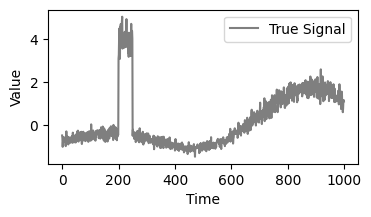

In [12]:
test = y_tildes_test
training = y_tildes
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
axs.plot(test.flatten(), label='True Signal', alpha=0.5, color='black')
# axs[0].plot(ys , label='clean signal')
axs.legend()
# axs.grid()
axs.set_xlabel("Time")
axs.set_ylabel("Value")
# axs.set_ylim(-2, 6)
# plt.savefig("toy_example_30.png", bbox_inches='tight', dpi=300)
plt.show() 

3. Predict aleatoric uncertainty and Plot result

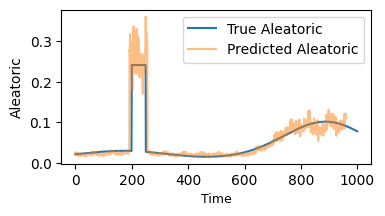

In [ ]:

from dataloader import AEReconLoader

test_recons_dataset = AEReconLoader(test, config.win_size, "test")

batch_size = 1
test_recons_dataloader =  DataLoader(
    dataset = test_recons_dataset, 
    batch_size = batch_size,
    shuffle=False,
    drop_last=True,
)


recstructed_signal = []
approx_var_heter = []

bae_ens.eval()

for i, x in enumerate(test_recons_dataloader):
    x = x.view(batch_size, config.in_channel, -1)
    x = x.to(config.device)
    prediction, var = bae_ens.predict_mean_var(x)

    recstructed_signal.extend(prediction.detach().cpu().numpy().flatten())
    approx_var_heter.extend(var.detach().cpu().numpy().flatten())

recstructed_signal = np.array(recstructed_signal)
approx_var_heter = np.array(approx_var_heter)
true_var_heter = ((generator.get_y_std(data['y_disturb']) / scaler.scale_)**2).detach().numpy().flatten()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
axs.plot(true_var_heter, label='True Aleatoric')
axs.plot(approx_var_heter, label='Predicted Aleatoric', alpha=0.5)
# axs.grid()
# axs.set_ylim(0, 1)
axs.legend()
axs.set_xlabel("Time", fontsize=9)
axs.set_ylabel("Aleatoric", fontsize=10)
# plt.savefig("result_4_28/anomaly_40_nll.png",bbox_inches='tight', dpi=300)
plt.show() 

